<a href="https://colab.research.google.com/github/QcoJuanDavidMarin/Diplomado/blob/master/ProyectofinalDiplomadoJDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="color:green"><center>**Diplomado en Inteligencia Artificial y Aprendizaje Profundo**</center></span>


## <span style="color:red"><center>Proyecto final del diplomado, </center></span>

## <span style="color:red"><center>DETECCIÓN Y LOCALIZACIÓN DE TUMORES CEREBRALES MEDIANTE RECONOCIMIENTO DE IMAGENES DE RESONANCIA MAGNETICA</center></span>

* <span style="color:red"><center>Por Juan David Marín</center></span>

Este es un proyecto enfocado específicamente al sector de la salud, al sector de la sanidad y de la medicina. Especificamente se trata de analizar todas las imágenes de una de una una resonancia magnética del cerebro.


[fuente de los datos](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation)

## Importar librerias 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import zipfile
import cv2
from skimage import io  # procesamiento de imágenes 
import tensorflow as tf 
from tensorflow.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121 ## Densenet121
from tensorflow.keras.applications.resnet50 import ResNet50 ## ResNet50, red neuronal residual
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform #Extraer muestras de una distribución uniforme
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K  
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob # buscador todos los nombres de ruta que coinciden con un patrón especificado
import random
from google.colab import files #Librería para cargar ficheros directamente en Colab
%matplotlib inline



In [4]:
# montar disco usando los siguientes comandos:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Navegar hasta el directorio My Drive para cambiar el directorio de trabajo
%cd /content/drive/MyDrive/Proyecto final Diplomado IAAP /Healthcare AI Datasets/Brain_MRI

/content/drive/MyDrive/Proyecto final Diplomado IAAP /Healthcare AI Datasets/Brain_MRI


In [6]:
# Datos que contienen la ruta a Brain MRI y su máscara correspondient donde uno indica si tiene cancer y cero que no
brain_df = pd.read_csv('data_mask.csv')
brain_df.head()


,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [6]:
# Ruta a la imagen de la resonancia magnetica para el primer paciente
brain_df.mask_path[0] 

'TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_mask.tif'

In [ ]:
# Ruta máscara de segmentación para el primer paciente
brain_df.image_path[0] 

'TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif'

In [48]:
# Contar cuantos casos son 1 y cuantos son 0
print('Total de de cada categoria','\n', brain_df['mask'].value_counts()[0], '\n')

print('Categorias en total', brain_df['mask'].value_counts().index)

Total de de cada categoria 
 2556 

Categorias en total Int64Index([0, 1], dtype='int64')


In [58]:
x1 = brain_df['mask'].value_counts()[0]
x2 = brain_df['mask'].value_counts()[1]
print(x1)
print(x2)

2556
1373


In [59]:
y1 = brain_df['mask'].value_counts().index[0]
y2 = brain_df['mask'].value_counts().index[1]
print(y1)
print(y2)

0
1


In [64]:
# diagrama de barras de las categorias
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts(), name='MASK')])
fig.update_traces(marker_color = 'rgb(200,0,0)', marker_line_color = 'rgb(260,0,0)',marker_line_width = 8, opacity = 0.5)
fig.update_layout(barmode='group')

fig.update_yaxes(title_text="mask")
fig.show()


In [65]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [69]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

## Mostrar una imagen de una mascara

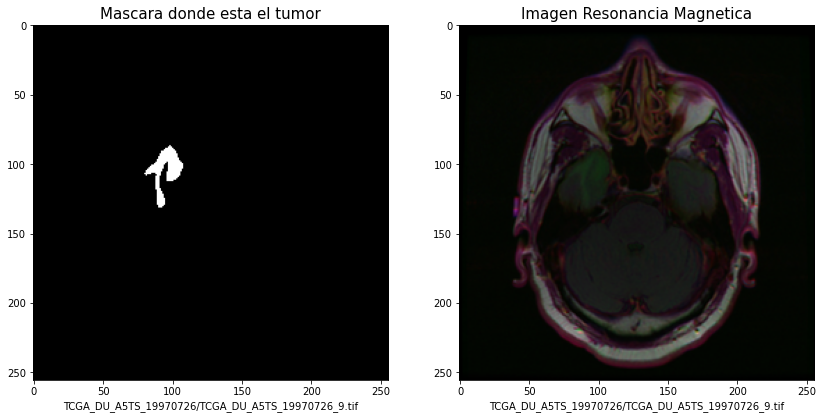

In [116]:
plt.figure(figsize = (14,7))
plt.subplot(121)
plt.imshow(cv2.imread(brain_df.mask_path[923]))
plt.title('Mascara donde esta el tumor', fontsize = 15)
plt.xlabel(brain_df.image_path[923])

plt.subplot(122)
plt.imshow(cv2.imread(brain_df.image_path[923]))
plt.title('Imagen Resonancia Magnetica', fontsize = 15)
plt.xlabel(brain_df.image_path[923])
plt.show()

In [142]:
print('La dimención maxima de la imagen de la mascara es', cv2.imread(brain_df.mask_path[923]).max())
print('La dimención minima de la imagen de la mascara es', cv2.imread(brain_df.mask_path[923]).min())
print('\n')
print('La dimención maxima de la imagen de resonancia magnetica es', cv2.imread(brain_df.image_path[923]).max())
print('La dimención minima de la imagen de resonancia magnetica es', cv2.imread(brain_df.image_path[923]).min())

La dimención maxima de la imagen de la mascara es 255
La dimención minima de la imagen de la mascara es 0


La dimención maxima de la imagen de resonancia magnetica es 210
La dimención minima de la imagen de resonancia magnetica es 0


In [125]:
len(brain_df.image_path)


3929

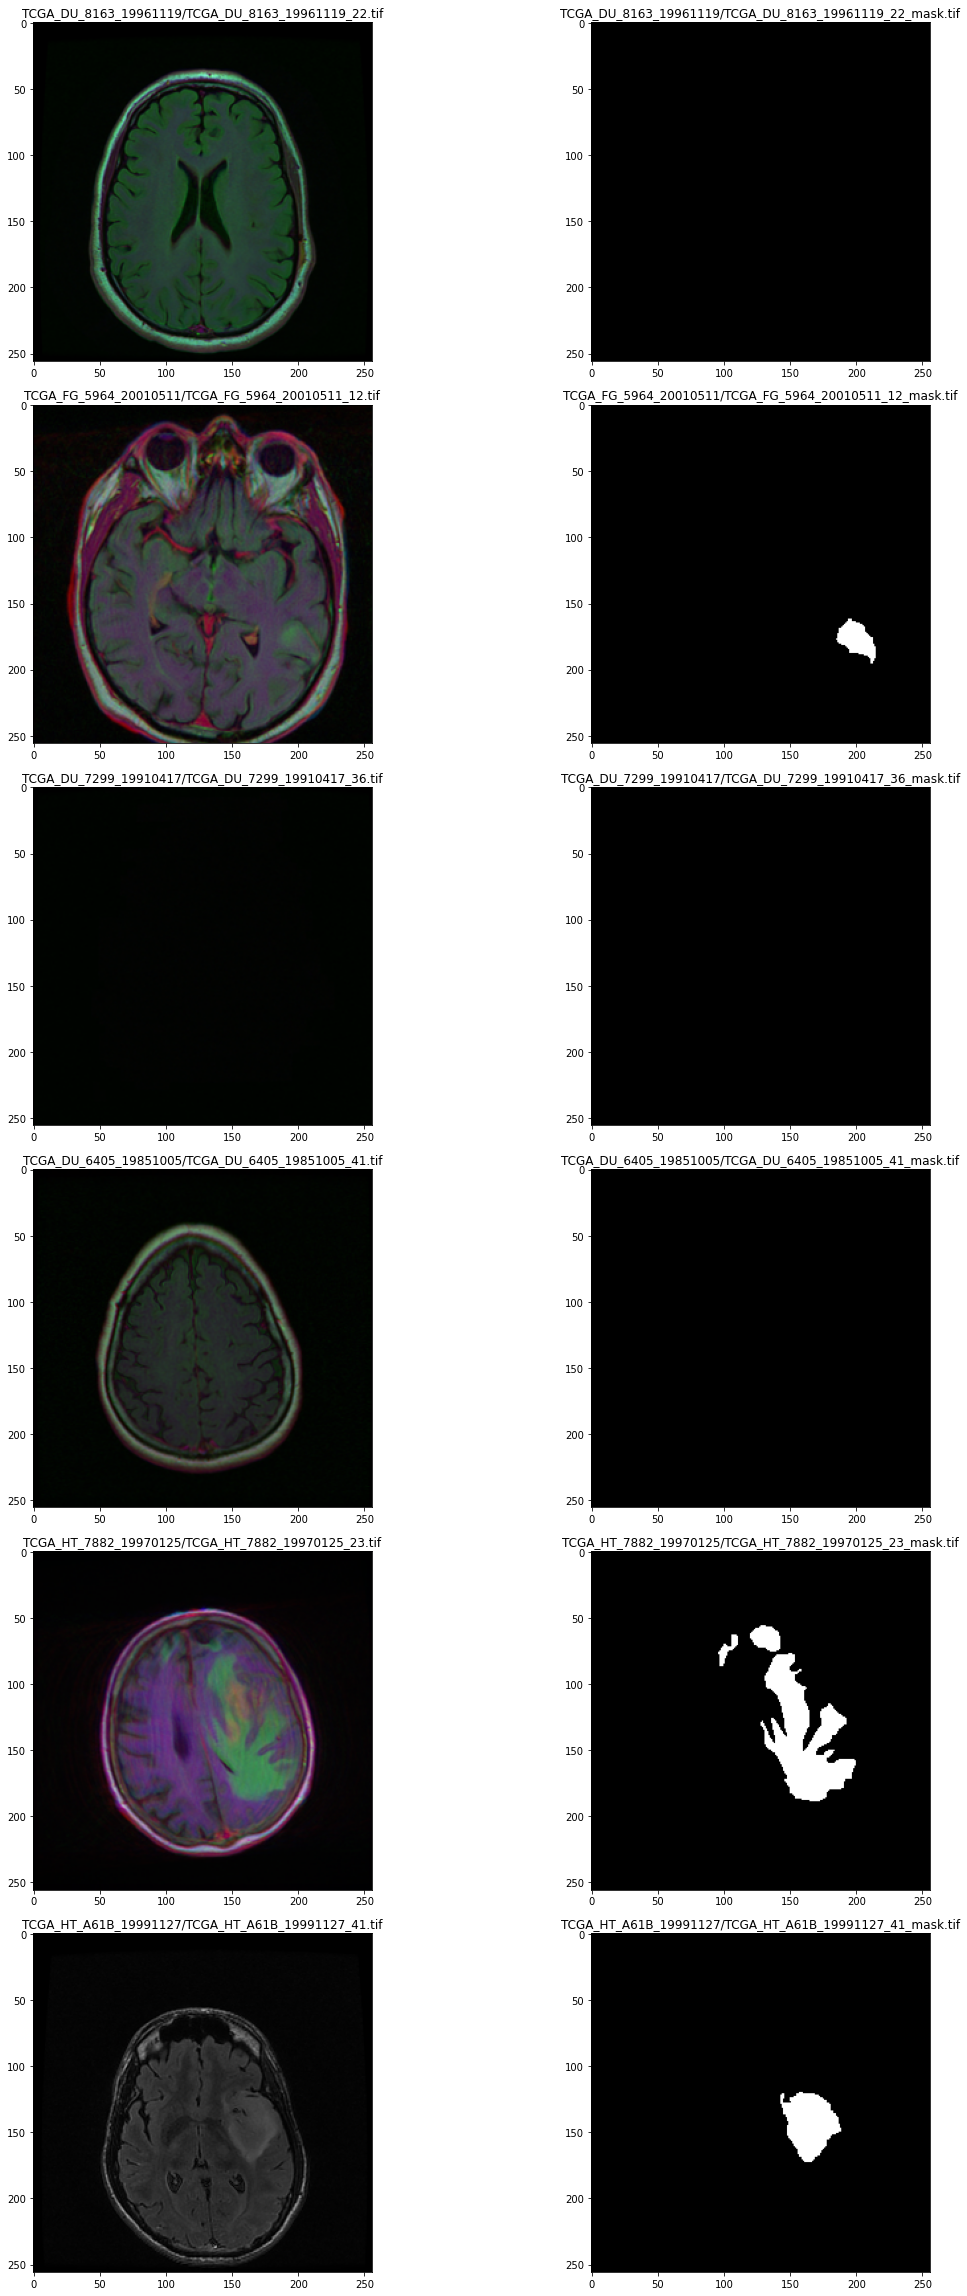

In [141]:
fig, ax = plt.subplots(6,2, figsize= (16,32))
count = 0
for x in range(6):
  i = random.randint(0,len(brain_df))
  ax[count][0].title.set_text(brain_df.image_path[i])
  ax[count][0].imshow(cv2.imread(brain_df.image_path[i]))
  ax[count][1].title.set_text(brain_df.mask_path[i])
  ax[count][1].imshow(cv2.imread(brain_df.mask_path[i]))
  count += 1
fig.tight_layout() # Ajustar en ancho y alto de la zona de dibujo

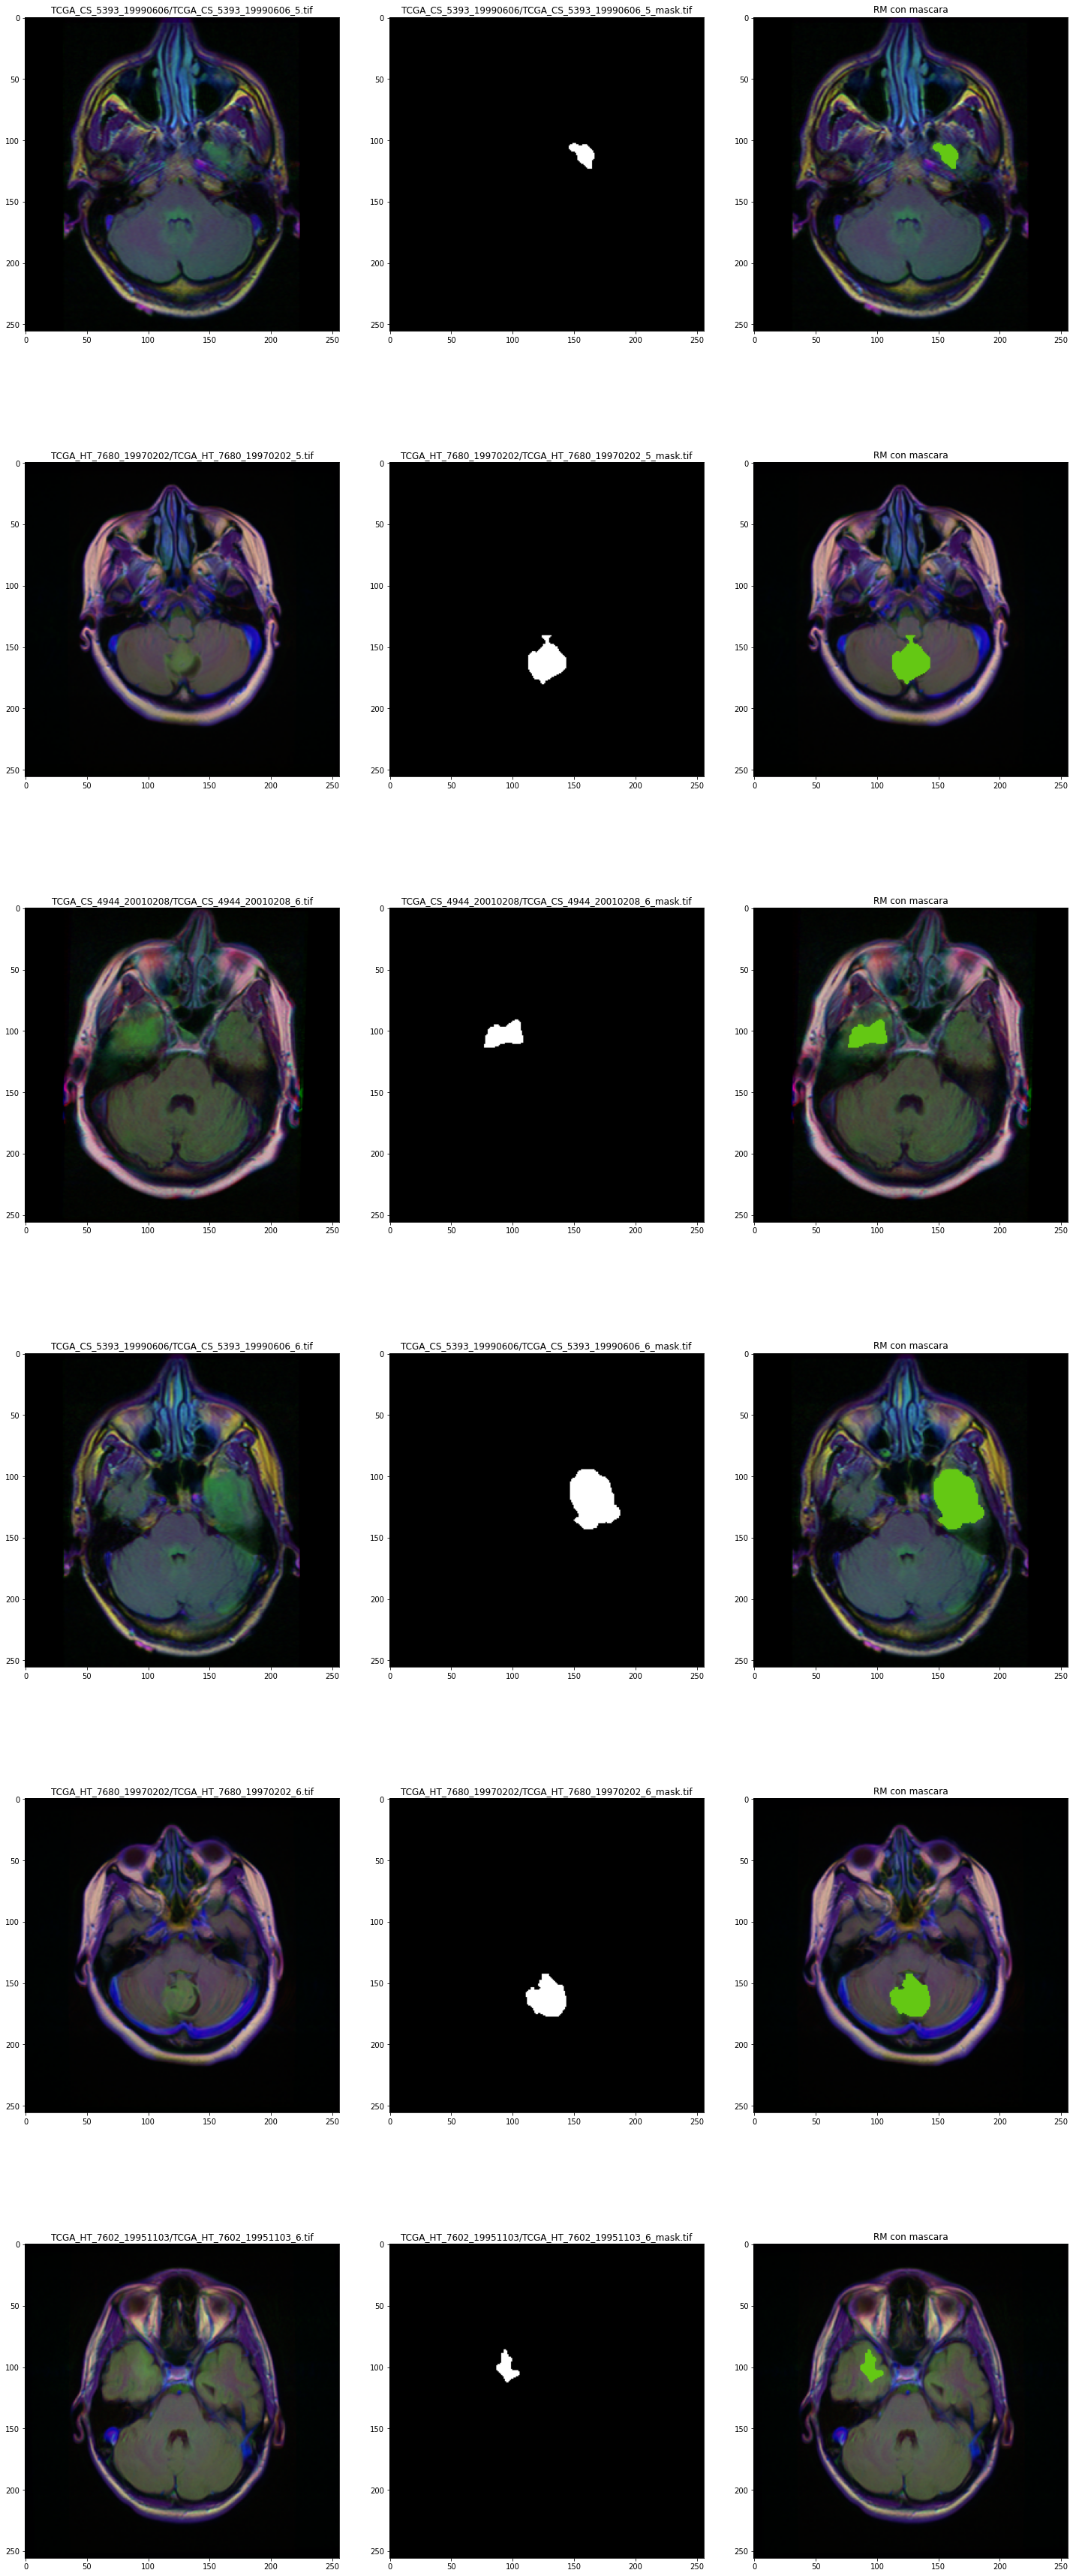

In [175]:
fig, ax = plt.subplots(6, 3, figsize = (20, 50))
count = 0
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count <6:

    img = io.imread(brain_df.image_path[i])
    ax[count][0].title.set_text(brain_df.image_path[i])
    ax[count][0].imshow(img)
    mascara = io.imread(brain_df.mask_path[i])
    ax[count][1].title.set_text(brain_df.mask_path[i])
    ax[count][1].imshow(mascara,cmap  = 'gray')
  
    img[mascara == 255] = (100, 200, 20)
    ax[count][2].title.set_text('RM con mascara')
    ax[count][2].imshow(img)
    count += 1

fig.tight_layout() # Ajustar en ancho y alto de la zona de dibujo

# MODELO de CLASIFICADOR PARA DETECTAR SI EXISTE TUMOR O NO

In [97]:
# Eliminamos la columna de identificador del paciente porque no aporta a la construcción del modelo
brain_df_train = brain_df.drop(columns = ['patient_id'])
print('Tamaño datos originales', brain_df.shape)
print('Tamaño del nuevo conjunto de datos',brain_df_train.shape)

Tamaño datos originales (3929, 4)
Tamaño del nuevo conjunto de datos (3929, 3)


In [98]:
# Convertir los datos en la columna de máscara a formato de string, porque para ingresar tensorflow en flow_from_dataframe los datos deben ser en strings 

brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
#brain_df_train['mask'] = str(brain_df_train['mask'])
print(brain_df.info(), '\n')
print(brain_df_train.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB
None


# Dividir los datos en entrenamiento y testing

In [99]:
from sklearn.model_selection import train_test_split

In [100]:
train, test = train_test_split(brain_df_train, train_size = 0.2)

In [101]:
brain_df_train['mask'].value_counts().index


Index(['0', '1'], dtype='object')

In [102]:
# Cargar imagenes por batches

from tensorflow.keras.preprocessing.image import ImageDataGenerator # Preprocesar las imagenes que van a estrar al algoritmo 

In [103]:
# Generador de datos
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.15) # Validation_split para que la Red no memorize 

In [104]:
# Dimension de las imagenes 
cv2.imread(brain_df.mask_path[923]).shape

(256, 256, 3)

# Generando data de entrenamiento 

In [106]:
train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory  = './',
    x_col = 'image_path',
    y_col = 'mask', # Lo que se quiere predecir 
    subset= 'training',
    batch_size = 16,
    shuffe = True,
    class_mode = 'categorical',
    target_size = (256,256))

Found 668 validated image filenames belonging to 2 classes.


# Generando data de validación 

In [107]:
valid_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    subset = 'validation',
    batch_size = 16,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (256,256))

Found 117 validated image filenames belonging to 2 classes.


# Imagenes de prueba 

In [109]:
test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    batch_size = 16,
    shuffle = False,
    class_mode = 'categorical',
    target_size = (256,256))

Found 3144 validated image filenames belonging to 2 classes.



#<span style="color:red"><center>**Modelo base ResNet50**</center></span>

In [112]:

basemodel = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
# Se ajusta a falso el parámetro de include_top, ya que no es necesario, más adelante se acoplará la salida de dos categorías que se refieren a detectado o no detectado

94773248/94765736 [==============================] - 1s 0us/step


In [115]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [114]:
# Congelar los pesos del modelo para que no se entrene mas ninguna de las capas
for layer in basemodel.layers:
  layers.trainable = False

In [118]:
# Agregar al final la clasificación binaria al modelo base
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name='Flatten')(headmodel)

headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)

headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)

headmodel = Dense(2, activation='sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
# Agregamos una cabecera de clasificación al modelo base

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [119]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# Compilar el modelo

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks

In [122]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'modeloJDM.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath="clasificadorJDM.hdf5", 
                             verbose=1,
                             save_best_only=True)

# parada temprana para salir del entrenamiento si la pérdida en la validación no disminuye incluso después de ciertas épocas (paciencia)
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20)


# called every epoch
callbacks = [lr_reducer, checkpoint,earlystopping  ]